In [1]:
import gzip
import json
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path
import pandas as pd

from datetime import datetime
from dateutil.relativedelta import *
from notebook_utils import configure_path, setup_matplotlib

In [2]:
configure_path()
setup_matplotlib()

## Presence at Venezuelan Peering Facilities

While a thriving market of peering facilities may reveal a country’s prosperity in terms of Internet connectivity, the number of networks present at each facility is key to understanding the impact of these infrastructures. Our analysis now investigates the growth trends in the number of networks connected to each peering facility in Venezuela over time. This examination offers valuable insights into the country’s dynamic evolution of network interconnectivity.

In [3]:
rir = pd.read_csv("data/external/rir.csv")


To evaluate the number of networks connected to each peering facility in Venezuela, we utilize monthly snapshots from PeeringDB.

This data can be downloaded from CAIDA's Data Server (https://publicdata.caida.org/datasets/peeringdb-v2)

In [4]:
START_DATE = datetime(2018, 4, 1)
END_DATE = datetime(2024, 4, 1)

In [5]:
def get_country_facilities(cc):
    if not type(cc) == list and not isinstance(cc, np.ndarray):
        cc = [
            cc,
        ]

    d = START_DATE
    fac_cc = pd.DataFrame()

    while d < END_DATE:
        pdb_filename = f"data/raw/03-15-peeringdb/peeringdb_2_dump_{d.year}_{d.month:02d}_01.json.gz"

        if os.path.exists(pdb_filename):
            with gzip.open(pdb_filename, "r") as f:
                pdb = json.load(f)

            fac = pd.DataFrame(pdb["fac"]["data"])
            tmp_fac_cc = fac.loc[fac["country"].isin(cc)].drop_duplicates("name")
            tmp_fac_cc["snapshot"] = np.repeat(d, tmp_fac_cc.shape[0])
            fac_cc = pd.concat([fac_cc, tmp_fac_cc])

        d += relativedelta(months=+1)

    return fac_cc

In [6]:
fac_ve = get_country_facilities("VE")

In [12]:
fac_ve.head()

,org_name,website,updated,clli,name,created,net_count,address1,notes,org_id,...,aka,name_long,ix_count,diverse_serving_substations,available_voltage_services,property,region_continent,status_dashboard,social_media,campus_id
4295,Lumen Technologies Inc,https://www.lumen.com/,2021-10-12T20:41:34Z,,Lumen La Urbina,2021-10-12T17:22:18Z,1,"Edificio Century Link, Calle 7, La Urbina",,682,...,,,0.0,None,[],None,South America,NaN,NaN,NaN
4303,"Dayco Telecom, C.A.",https://daycohost.com/,2021-10-16T21:16:37Z,,Daycohost - Caracas,2021-10-15T19:56:44Z,1,Centro Tecnológico Daycohost,,14780,...,,,0.0,None,[],None,South America,NaN,NaN,NaN
4292,Lumen Technologies Inc,https://www.lumen.com/,2021-10-12T20:41:34Z,,Lumen La Urbina,2021-10-12T17:22:18Z,1,"Edificio Century Link, Calle 7, La Urbina",,682,...,,,0.0,None,[],None,South America,NaN,NaN,NaN
4300,"Dayco Telecom, C.A.",https://daycohost.com/,2021-10-16T21:16:37Z,,Daycohost - Caracas,2021-10-15T19:56:44Z,1,Centro Tecnológico Daycohost,,14780,...,,,0.0,None,[],None,South America,NaN,NaN,NaN
4289,Lumen Technologies Inc,https://www.lumen.com/,2021-10-12T20:41:34Z,,Lumen La Urbina,2021-10-12T17:22:18Z,2,"Edificio Century Link, Calle 7, La Urbina",,682,...,,,0.0,None,[],None,South America,NaN,NaN,NaN


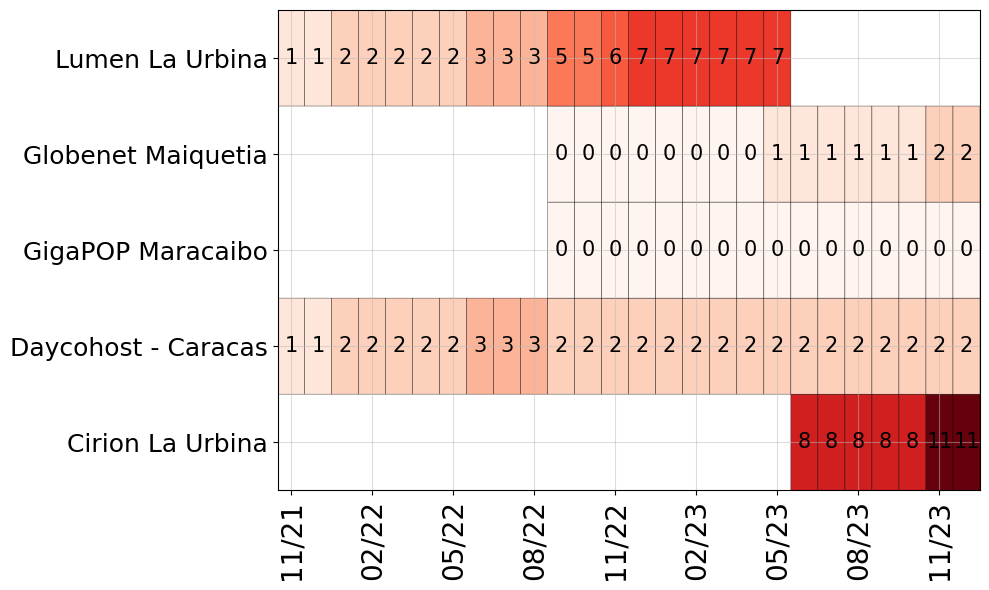

In [8]:
fig, ax = plt.subplots(1, figsize=(10, 6))

ax.yaxis.grid(True, linestyle="-", color="#bababa", alpha=0.5, which="both")
ax.xaxis.grid(True, linestyle="-", color="#bababa", alpha=0.5, which="both")

p = fac_ve.pivot(index="name", columns="snapshot")["net_count"]
t = p.columns
idx = p.index
p = p.to_numpy()

heatmap = ax.pcolor(
    p,
    norm=colors.Normalize(
        vmin=0,
        vmax=fac_ve["net_count"].max(),
    ),
    cmap="Reds",
    edgecolors="k",
)

for i in range(p.shape[0]):
    for j in range(p.shape[1]):
        if not np.isnan(p[i][j]):
            ax.annotate(
                f"{int(p[i][j]):d}",
                (j + 0.5, i + 0.5),
                fontsize=15,
                color="black",
                va="center",
                ha="center",
                rotation=0,
            )

ax.set_yticks(np.arange(len(idx)) + 0.5)
ax.set_yticklabels(fontsize=18, labels=idx)

i = np.arange(0, len(t), 1 * 3)
ax.set_xticks(i + 0.5)
ax.set_xticklabels(
    fontsize=20, labels=[t[_i].strftime("%m/%y") for _i in i], rotation=90
)

fig.subplots_adjust(hspace=0)
fig.tight_layout()
fig.savefig("figures/15-ve_peering_facilities.pdf")

 The figure illustrates the growth in the number of networks at each facility since November 2021, marking the emergence of Venezuela’s first peering facility on PeeringDB. Venezuela currently has only four peering facilities, with despair but mostly minimal presence of networks. Since 2021, the distribution of network connections across these facilities has been uneven: GIGA POP has no network presence, DaycoHost and GlobeNet have a minimal presence (2 networks each), while Cirion has experienced a rapid but still moderate increase in network connections (peaking 11 networks in the latest snapshot). These numbers highlight that Venezuela still lacks a domestic market demanding peering locations, and the presence of foreign players at these facilities to serve domestic networks is also minimal.

# Networks present at these facilities

In [9]:
def get_country_networks_at_facilities(cc):
    if not type(cc) == list and not isinstance(cc, np.ndarray):
        cc = [
            cc,
        ]

    d = START_DATE

    netfac = pd.DataFrame()
    while d < END_DATE:
        pdb_filename = (
            f"data/raw/peeringdb/peeringdb_2_dump_{d.year}_{d.month:02d}_01.json.gz"
        )

        if os.path.exists(pdb_filename):
            with gzip.open(pdb_filename, "r") as f:
                pdb = json.load(f)

            fac = pd.DataFrame(pdb["fac"]["data"])
            tmp_fac_cc = fac.loc[fac["country"].isin(cc)].drop_duplicates("name")

            tmp_net_cc = pd.DataFrame(pdb["netfac"]["data"])
            tmp_net_cc = tmp_net_cc.loc[tmp_net_cc["fac_id"].isin(tmp_fac_cc["id"])]
            tmp_net_cc["snapshot"] = np.repeat(d, tmp_net_cc.shape[0])

            net = pd.DataFrame(pdb["net"]["data"])[["asn", "name"]]

            tmp_net_cc = pd.merge(
                tmp_net_cc, net, left_on="local_asn", right_on="asn", how="left"
            )

            netfac = pd.concat([tmp_net_cc, netfac])

        d += relativedelta(months=+1)

    return netfac

In [10]:
netfac_ve = get_country_networks_at_facilities("VE")

In [11]:
netfac_ve.drop_duplicates(["name_x", "local_asn"])[["name_x", "local_asn", "name_y"]]

,name_x,local_asn,name_y
0,Cirion La Urbina,8053,IFX Venezuela
1,Daycohost - Caracas,8053,IFX Venezuela
2,Cirion La Urbina,265641,CIX BROADBAND
3,Daycohost - Caracas,269832,MDSTELECOM
4,Cirion La Urbina,269832,MDSTELECOM
5,Cirion La Urbina,23379,Blackburn Technologies II
6,Cirion La Urbina,270042,RED DOT TECHNOLOGIES
7,Cirion La Urbina,269738,Chircalnet Telecom
8,Cirion La Urbina,267809,360NET
9,Globenet Maiquetia,272102,BESSER SOLUTIONS


The table further expands the analysis by displaying the networks reported to be present at some point in Venezuela's peering facilities. As indicated in the table, neither hypergiants (e.g., Google, Cloudflare) nor large transit networks are present in these peering facilities.
